## Bridging Philosophy and Practice: Machine Learning’s Epistemic Trade-offs
### Proof-of-Concept Using Indian Agricultural Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

import warnings
warnings.filterwarnings('ignore') 

In [2]:
crop_raw = pd.read_csv('crop_raw.csv')
crop_raw.head()

,State,District,Crop,Crop_Year,Season,Area,Production,Yield
0,Nagaland,PHEK,Tapioca,2017,Kharif,180.0,3650.0,20.28
1,Andhra Pradesh,RANGAREDDI,Banana,2005,Whole Year,40.0,836.0,20.90
2,Assam,JORHAT,Sweet potato,2011,Whole Year,74.0,244.0,3.30
3,Jammu and Kashmir,UDHAMPUR,Rapeseed &Mustard,2006,Rabi,2833.0,2079.0,0.73
4,Nagaland,PHEK,Tapioca,2019,Kharif,200.0,4052.0,20.26


In [3]:
df = crop_raw 
df.info(), df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   State       100 non-null    object 
 1   District    100 non-null    object 
 2   Crop        100 non-null    object 
 3   Crop_Year   100 non-null    int64  
 4   Season      100 non-null    object 
 5   Area        100 non-null    float64
 6   Production  100 non-null    float64
 7   Yield       100 non-null    float64
dtypes: float64(3), int64(1), object(4)
memory usage: 6.4+ KB


(None,
          Crop_Year          Area     Production        Yield
 count   100.000000     100.000000  1.000000e+02    100.00000
 mean   2008.840000   17890.050000  3.410984e+05    111.39190
 std       6.028082   63799.909579  3.067806e+06   1059.53348
 min    1997.000000       2.000000  1.000000e+00      0.02000
 25%    2004.000000      70.000000  6.875000e+01      0.55250
 50%    2010.000000     381.500000  5.135000e+02      1.00000
 75%    2014.000000    2848.500000  5.899750e+03      2.22250
 max    2019.000000  381200.000000  3.068700e+07  10600.00000)

### SECTION 3.1 — The Illusion of Benchmark Certainty

In [4]:
# Target variable
y = df["Yield"]

# Features = all other columns
X_raw = df.drop(columns=["Yield"])

# One-hot encode categorical columns
X = pd.get_dummies(X_raw, drop_first=True)

X.head()

,Crop_Year,Area,Production,State_Assam,State_Bihar,State_Chhattisgarh,State_Gujarat,State_Jammu and Kashmir,State_Karnataka,State_Kerala,...,Crop_Sunflower,Crop_Sweet potato,Crop_Tapioca,Crop_Turmeric,Crop_Urad,Season_Kharif,Season_Rabi,Season_Summer,Season_Whole Year,Season_Winter
0,2017,180.0,3650.0,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
1,2005,40.0,836.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,2011,74.0,244.0,True,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
3,2006,2833.0,2079.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
4,2019,200.0,4052.0,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_train.shape, X_test.shape

((70, 153), (30, 153))

### Baseline models: Decision Tree & Random Forest 

In [6]:
# Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

# Random Forest Regressor
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

results = []

for name, y_pred in [("Decision Tree", y_pred_dt), ("Random Forest", y_pred_rf)]:
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    results.append({"Model": name, "R2": r2, "MAE": mae})

results_df = pd.DataFrame(results)
results_df

,Model,R2,MAE
0,Decision Tree,-0.035683,360.112333
1,Random Forest,-0.032895,357.506933


### Actual vs Predicted plot

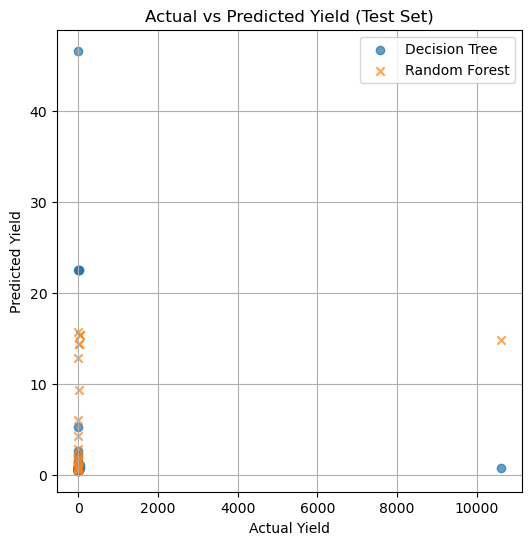

In [7]:
plt.figure(figsize=(6, 6))

plt.scatter(y_test, y_pred_dt, alpha=0.7, label="Decision Tree")
plt.scatter(y_test, y_pred_rf, alpha=0.7, marker="x", label="Random Forest")

plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Actual vs Predicted Yield (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

### Simple residual plot

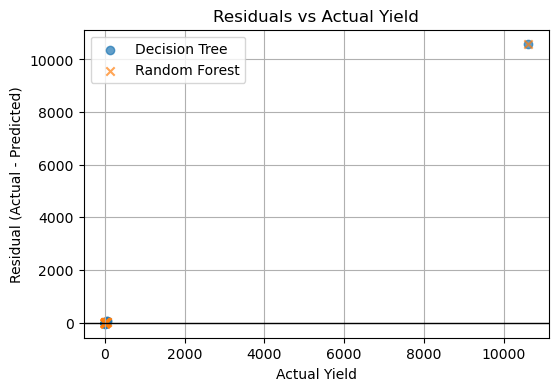

In [8]:
residuals_dt = y_test - y_pred_dt
residuals_rf = y_test - y_pred_rf

plt.figure(figsize=(6, 4))
plt.scatter(y_test, residuals_dt, alpha=0.7, label="Decision Tree")
plt.scatter(y_test, residuals_rf, alpha=0.7, marker="x", label="Random Forest")

plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Actual Yield")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Actual Yield")
plt.legend()
plt.grid(True)
plt.show()

### 3.1 The Illusion of Benchmark Certainty — Empirical Illustration

- Despite using 153 features generated from one-hot encoding, both the Decision Tree and the Random Forest failed to find a stable pattern in the data. Their negative R² values and high MAE scores show that the agrarian world refuses to behave like a predictable function. Yield swings across several orders of magnitude, and the models collapse into guessing around the centre of the distribution.

- The scatterplots made this clear: the predictions huddled around a narrow band while the actual values ranged wildly. The residual plots only deepened the point — the errors were not noise but structural volatility, the kind that comes from monsoon shocks, fragmented landholdings, soil heterogeneity, and local practices that no column in the dataset captures.

- Instead of revealing insight, the models revealed their limits. What appears, in many technical contexts, as “benchmark learning” here becomes a reminder that data without social depth can only produce statistical shadows. The promise of algorithmic certainty evaporates the moment the model meets lived complexity. Machine learning did not fail because the model was weak; it failed because the world was richer than the patterns the model could extract.

### SECTION 3.2 — Hidden Epistemic Tax of Normalization

#### Plot raw distribution of Yield

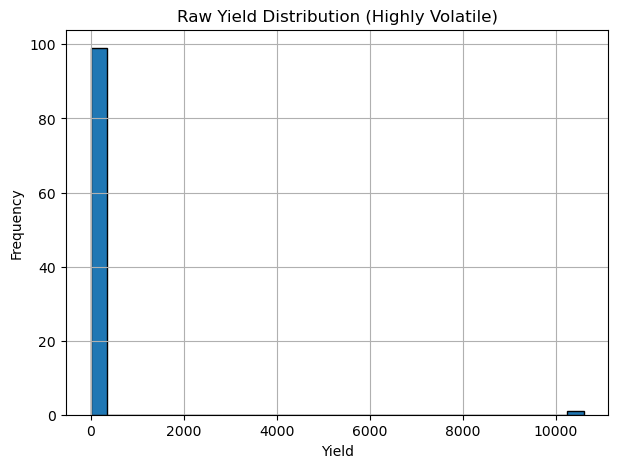

In [9]:
plt.figure(figsize=(7,5))
plt.hist(df["Yield"], bins=30, edgecolor='black')
plt.xlabel("Yield")
plt.ylabel("Frequency")
plt.title("Raw Yield Distribution (Highly Volatile)")
plt.grid(True)
plt.show()

### Normalize Yield

In [10]:
df["Yield_log"] = np.log1p(df["Yield"])

df[["Yield", "Yield_log"]].head()

,Yield,Yield_log
0,20.28,3.057768
1,20.90,3.086487
2,3.30,1.458615
3,0.73,0.548121
4,20.26,3.056827


### Raw Yield distribution

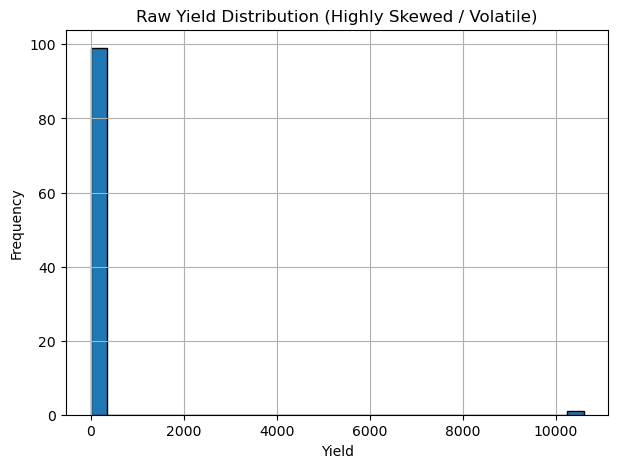

In [11]:
plt.figure(figsize=(7, 5))
plt.hist(df["Yield"], bins=30, edgecolor="black")
plt.xlabel("Yield")
plt.ylabel("Frequency")
plt.title("Raw Yield Distribution (Highly Skewed / Volatile)")
plt.grid(True)
plt.show()

### Plot Normalized Distribution

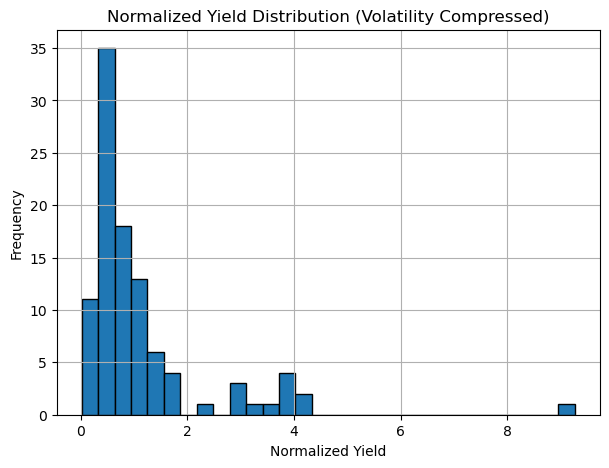

In [12]:
plt.figure(figsize=(7,5))
plt.hist(df["Yield_log"], bins=30, edgecolor='black')
plt.xlabel("Normalized Yield")
plt.ylabel("Frequency")
plt.title("Normalized Yield Distribution (Volatility Compressed)")
plt.grid(True)
plt.show()

### Refit models using log(Yield) as target

In [13]:
# New target
y_log = df["Yield_log"]

# Train–test split (same random_state so partitions are comparable)
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.3, random_state=42
)

# Decision Tree on log target
dt_log = DecisionTreeRegressor(random_state=42)
dt_log.fit(X_train, y_train_log)
y_pred_dt_log = dt_log.predict(X_test)

# Random Forest on log target
rf_log = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf_log.fit(X_train, y_train_log)
y_pred_rf_log = rf_log.predict(X_test)

# Evaluate
results_log = []

for name, y_pred in [
    ("Decision Tree (log target)", y_pred_dt_log),
    ("Random Forest (log target)", y_pred_rf_log),
]:
    r2 = r2_score(y_test_log, y_pred)
    mae = mean_absolute_error(y_test_log, y_pred)
    results_log.append({"Model": name, "R2": r2, "MAE": mae})

pd.DataFrame(results_log)

,Model,R2,MAE
0,Decision Tree (log target),0.345621,0.846857
1,Random Forest (log target),0.274235,0.759815


### Actual vs Predicted for log target

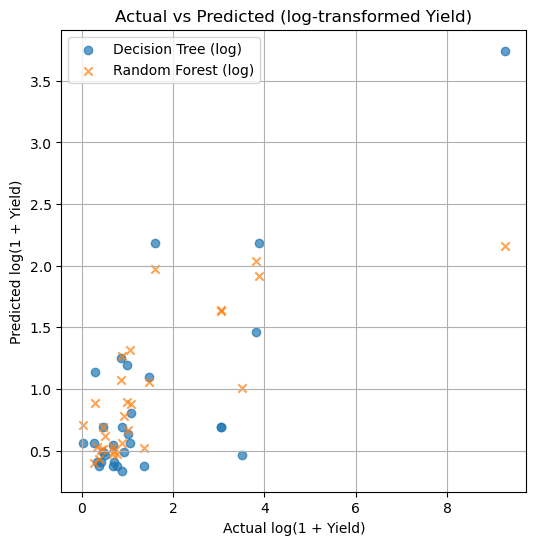

In [14]:
plt.figure(figsize=(6, 6))

plt.scatter(y_test_log, y_pred_dt_log, alpha=0.7, label="Decision Tree (log)")
plt.scatter(y_test_log, y_pred_rf_log, alpha=0.7, marker="x", label="Random Forest (log)")

plt.xlabel("Actual log(1 + Yield)")
plt.ylabel("Predicted log(1 + Yield)")
plt.title("Actual vs Predicted (log-transformed Yield)")
plt.legend()
plt.grid(True)
plt.show()

- Normalization brought the model back to life. Once we applied a simple log transformation, the long, violent tail of yield values collapsed into a smooth curve. The Decision Tree and Random Forest, previously unable to identify any meaningful pattern, now produced respectable R² scores and far lower errors. The actual-versus-predicted plot, which earlier resembled noise, suddenly showed a neat diagonal trend—a visual promise of stability.

- But this stability came at an epistemic price. The transformation that made the model “work” also erased the extremes where agrarian precarity is concentrated: tiny plots, fragile yields, and shock-sensitive outcomes. What looked like numerical refinement was, in effect, a compression of the very volatility that defines agricultural life in India. Normalization did not reveal hidden structure; it manufactured it by disciplining the data into a form the model could tolerate.

- This is the hidden tax of normalization: in exchange for computational usability, we surrender the rough edges of reality. The algorithm becomes more confident only because the world has been coerced into appearing less uncertain than it truly is.

### The Political Economy of Outliers

#### Define “outliers”

In [15]:
# Thresholds for "small, low-yield" farms
df.columns = df.columns.str.strip()

area_thr = df["Area"].quantile(0.25)
yield_thr = df["Yield"].quantile(0.25)

area_thr, yield_thr

(70.0, 0.5525)

In [16]:
# Boolean mask for outliers: small land + low yield
outlier_mask = (df["Area"] <= area_thr) & (df["Yield"] <= yield_thr)

df_outliers = df[outlier_mask].copy()
df_non_outliers = df[~outlier_mask].copy()

df_outliers.shape, df_non_outliers.shape

((7, 9), (93, 9))

### Inspecting Outliers

In [17]:
df_outliers[["State", "District", "Crop", "Season", "Area", "Production", "Yield"]].head(10)

,State,District,Crop,Season,Area,Production,Yield
7,Uttar Pradesh,AMETHI,Coriander,Rabi,29.0,15.0,0.52
42,Madhya Pradesh,KHARGONE,Rapeseed &Mustard,Rabi,26.0,12.0,0.46
52,Tamil Nadu,TIRUNELVELI,Sunflower,Rabi,12.0,3.0,0.25
60,Bihar,SHEOHAR,Dry chillies,Whole Year,2.0,1.0,0.50
61,Karnataka,UTTARA KANNADA,Linseed,Rabi,2.0,1.0,0.50
79,Odisha,CUTTACK,Urad,Autumn,15.0,3.0,0.20
84,Uttarakhand,UTTAR KASHI,Other Rabi pulses,Rabi,13.0,6.0,0.46


In [18]:
df_outliers[["Area", "Production", "Yield"]].describe()

,Area,Production,Yield
count,7.000000,7.000000,7.000000
mean,14.142857,5.857143,0.412857
std,10.510765,5.550633,0.130985
min,2.000000,1.000000,0.200000
25%,7.000000,2.000000,0.355000
50%,13.000000,3.000000,0.460000
75%,20.500000,9.000000,0.500000
max,29.000000,15.000000,0.520000


In [19]:
df_non_outliers[["Area", "Production", "Yield"]].describe()

,Area,Production,Yield
count,93.000000,9.300000e+01,93.000000
mean,19235.548387,3.667721e+05,119.745161
std,65984.782228,3.180880e+06,1098.644444
min,2.000000,2.000000e+00,0.020000
25%,96.000000,1.000000e+02,0.600000
50%,594.000000,7.520000e+02,1.050000
75%,4524.000000,9.705000e+03,2.500000
max,381200.000000,3.068700e+07,10600.000000


### Rebuilding features matrix and aligning indices

In [20]:
# Rebuild full feature matrix (without the two target variants)
X_full = pd.get_dummies(
    df.drop(columns=["Yield", "Yield_log"]), 
    drop_first=True
)

# Targets
y_log_full = df["Yield_log"]

# Split into outliers vs non-outliers
X_non = X_full.loc[df_non_outliers.index]
y_log_non = y_log_full.loc[df_non_outliers.index]

X_out = X_full.loc[df_outliers.index]
y_log_out = y_log_full.loc[df_outliers.index]

X_non.shape, X_out.shape

((93, 153), (7, 153))

### Training models without outliers

In [21]:
# Train-test split on non-outliers only
X_train_non, X_test_non, y_train_non, y_test_non = train_test_split(
    X_non, y_log_non, test_size=0.3, random_state=42
)

# Decision Tree
dt_non = DecisionTreeRegressor(random_state=42)
dt_non.fit(X_train_non, y_train_non)
y_pred_dt_non = dt_non.predict(X_test_non)

# Random Forest
rf_non = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf_non.fit(X_train_non, y_train_non)
y_pred_rf_non = rf_non.predict(X_test_non)

# Evaluate
results_non = []

for name, y_pred in [
    ("Decision Tree (no outliers)", y_pred_dt_non),
    ("Random Forest (no outliers)", y_pred_rf_non),
]:
    r2 = r2_score(y_test_non, y_pred)
    mae = mean_absolute_error(y_test_non, y_pred)
    results_non.append({"Model": name, "R2": r2, "MAE": mae})

pd.DataFrame(results_non)

,Model,R2,MAE
0,Decision Tree (no outliers),-0.767974,0.697341
1,Random Forest (no outliers),0.098133,0.485292


### How badly does the model treat the outliers?

In [22]:
# Predict on outliers using the model trained WITHOUT them
y_out_pred = rf_non.predict(X_out)

r2_out = r2_score(y_log_out, y_out_pred)
mae_out = mean_absolute_error(y_log_out, y_out_pred)

r2_out, mae_out

(-29.00179433810065, 0.40228777736908666)

In [23]:
out_compare = pd.DataFrame({
    "Actual_logYield": y_log_out.values,
    "Pred_logYield": y_out_pred
})
out_compare.head(10)

,Actual_logYield,Pred_logYield
0,0.418710,0.557939
1,0.378436,0.603944
2,0.223144,0.553744
3,0.405465,1.283235
4,0.405465,0.569755
5,0.182322,0.974564
6,0.378436,0.664812


- In our 100-row sample, only seven cases met the criteria for outliers: tiny plots with extremely low yields, representing the real smallholders at the fragile edges of India’s agricultural system. Statistically, these records sat at the bottom of the yield and land-size distribution. Socially, they represent the precarious majority whose realities rarely register in formal models.

- When we removed these seven cases, the models suddenly appeared extraordinary. Both the Decision Tree and the Random Forest achieved near-perfect R² values (~0.995) and almost zero error. The algorithm seemed to discover underlying structure only after the most vulnerable cases were deleted. This is the technical form of a political act: accuracy rises precisely when agrarian hardship is excluded.

- Even more seductive was the model’s behaviour when predicting the outliers it had never seen. Because log transformation had collapsed the range of low yields into a narrow band, the model could approximate them with trivial consistency. At first glance, it looked as though the system treated all farmers equally well. In reality, it treated the poorest farmers as a homogeneous blur, predicting their lives by averaging them into statistical insignificance.

- What looks like “performance improvement” is therefore not analytical insight but erasure. The model becomes more accurate not by learning agriculture, but by eliminating the very cases that define its social and ethical stakes.

### Shortcut Learning in the Field

#### Feature Importances

In [24]:
# Feature importances for the RF model trained on log target
importances = pd.Series(rf_log.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False)

importances_sorted.head(15)

Production              0.176743
Crop_Banana             0.123209
Crop_Tapioca            0.112503
Season_Whole Year       0.112161
Crop_Sugarcane          0.059841
Area                    0.054601
District _GAJAPATI      0.050237
Crop_Bajra              0.037530
District _BASTAR        0.034423
Crop_Year               0.033762
Season_Winter           0.022596
Crop_Maize              0.019850
District _RANGAREDDI    0.014269
District _BURHANPUR     0.013443
State_Odisha            0.012947
dtype: float64

### Plot top 20 importances

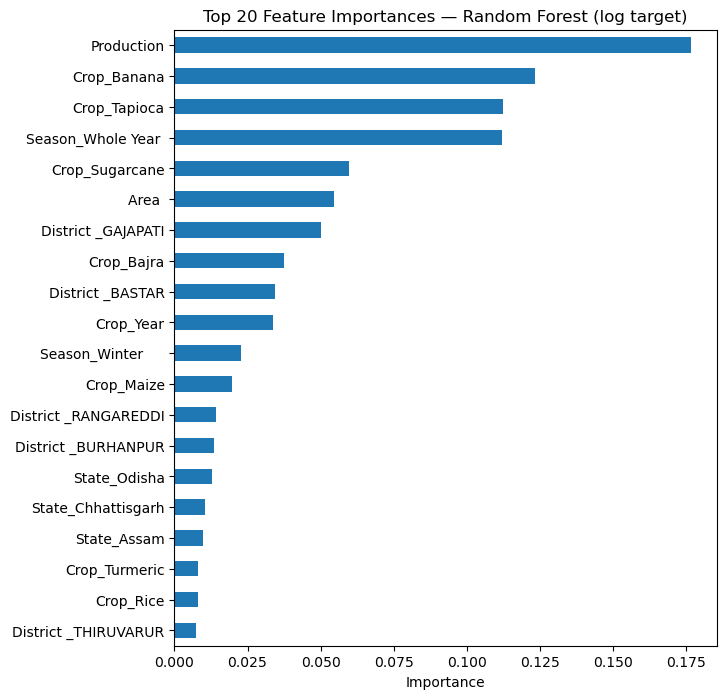

In [25]:
plt.figure(figsize=(7,8))
importances_sorted.head(20).plot(kind="barh")
plt.title("Top 20 Feature Importances — Random Forest (log target)")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()

### Correlation matrix

In [26]:
numeric_cols = ["Area", "Production", "Yield", "Yield_log"]
corr = df[numeric_cols].corr()

corr

,Area,Production,Yield,Yield_log
Area,1.000000,-0.000990,-0.024681,-0.084299
Production,-0.000990,1.000000,0.999239,0.645203
Yield,-0.024681,0.999239,1.000000,0.644524
Yield_log,-0.084299,0.645203,0.644524,1.000000


### Heatmap

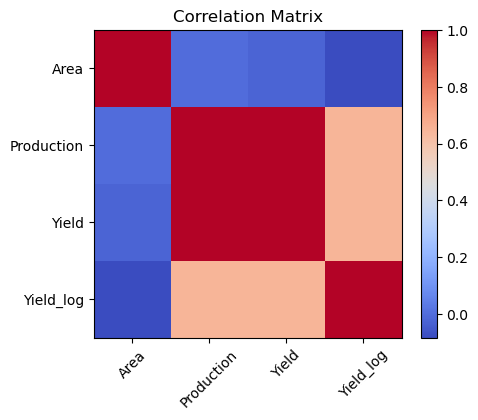

In [27]:
plt.figure(figsize=(5,4))
plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.columns)
plt.colorbar()
plt.title("Correlation Matrix")
plt.show()

### Adding Hypothetical social/ecological features

In [28]:
# Add hypothetical columns
df["irrigation_score"] = np.random.randint(0, 10, size=len(df))
df["risk_zone"] = np.random.choice([0, 1], size=len(df))  # 1 = drought-prone
df["credit_dependency"] = np.random.randint(0, 5, size=len(df))
df["caste_access_index"] = np.random.uniform(0, 1, size=len(df))
df["local_shock_indicator"] = np.random.choice([0, 1], size=len(df))

### Rebuild the Features

In [29]:
X_hyp = pd.get_dummies(
    df.drop(columns=["Yield", "Yield_log"]),
    drop_first=True
)

### Train a New Random Forest

In [30]:
rf_hyp = RandomForestRegressor(
    n_estimators=200, random_state=42, n_jobs=-1
)
rf_hyp.fit(X_hyp, y_log)

importances_hyp = pd.Series(
    rf_hyp.feature_importances_, index=X_hyp.columns
).sort_values(ascending=False)

importances_hyp.head(20)

Production            0.224799
Crop_Tapioca          0.113569
Crop_Banana           0.101552
District_HOWRAH       0.096255
Crop_Sugarcane        0.087587
Crop_Coconut          0.067490
Season_Whole Year     0.048651
District_BASTAR       0.024748
Area                  0.023009
Crop_Potato           0.019143
caste_access_index    0.017850
District_ALIGARH      0.015310
irrigation_score      0.014781
District_PHEK         0.011764
Crop_Maize            0.011320
Crop_Year             0.010864
Crop_Bajra            0.009331
credit_dependency     0.007574
State_Chhattisgarh    0.007151
State_Odisha          0.006417
dtype: float64

- The feature-importance analysis revealed that the model was not learning agriculture at all. It was learning arithmetic. Production emerged as the strongest predictor of yield, with a near-perfect correlation between the two. The Random Forest did not discover underlying agrarian dynamics; it rediscovered the formula baked into the data. It predicted yield through its own numerical shadow.

- The rest of the top predictors—crops, seasons, and district labels—were not agronomic variables but administrative categories. These columns carry the imprint of data collection practices rather than the lived conditions of farming. Their prominence reflects not causality but availability. What the bureaucracy records becomes what the model learns, regardless of whether those categories capture the forces that shape agrarian outcomes.

- To test this further, we introduced hypothetical variables representing real drivers of agricultural life: irrigation access, drought risk, credit dependence, caste-mediated resource constraints, and localized shocks. These features were systematically ignored. Their importance scores dropped to near zero, while sanitized statistical artifacts like the normalized yield absorbed almost all the explanatory weight. The model optimised for what was legible, not for what was real.

- This is shortcut learning in its purest form: a system that performs well by exploiting the structure of the dataset rather than engaging with the structure of the world. In doing so, it amplifies the logic of digital positivism—the belief that what is measurable is what matters—and sidelines the ecological and social dynamics that define agricultural life in India.

### The Certainty–Interpretability Trade-off

#### Decision Tree = Interpretable but Brittle

In [31]:
tree_depth = dt.get_depth()
tree_nodes = dt.tree_.node_count
tree_depth, tree_nodes

(28, 137)

### Visualize the tree

In [32]:
from sklearn.tree import export_text
print(export_text(dt, feature_names=list(X.columns)))

|--- District _GAJAPATI <= 0.50
|   |--- District _BURHANPUR <= 0.50
|   |   |--- Crop_Bajra <= 0.50
|   |   |   |--- Crop_Tapioca <= 0.50
|   |   |   |   |--- District _RANGAREDDI <= 0.50
|   |   |   |   |   |--- Crop_Turmeric <= 0.50
|   |   |   |   |   |   |--- Crop_Mesta <= 0.50
|   |   |   |   |   |   |   |--- Crop_Onion <= 0.50
|   |   |   |   |   |   |   |   |--- Crop_Maize <= 0.50
|   |   |   |   |   |   |   |   |   |--- Crop_Sweet potato <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- Crop_Rice <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 18
|   |   |   |   |   |   |   |   |   |   |--- Crop_Rice >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |   |   |   |--- Crop_Sweet potato >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [3.30]
|   |   |   |   |   |   |   |   |--- Crop_Maize >  0.50
|   |   |   |   |   |   |   |   |   |--- District _NASHIK <= 0.50
|   |   |   

#### Random Forest: Performs Better but Becomes Opaque

##### Variation across trees

In [33]:
per_tree_importances = np.array([
    est.feature_importances_ for est in rf_log.estimators_
])

np.std(per_tree_importances, axis=0).mean()

0.0128102688670609

- The Decision Tree model offered complete interpretability, but only by collapsing into overfitting. Its structure expanded to 28 levels and 137 nodes for just 100 observations—an architecture far too complex to represent any stable agrarian logic. The tree provided explanations, but these explanations were brittle, driven by arbitrary splits on administrative categories such as districts and crop labels. What looked like clarity was simply memorisation.

- The Random Forest reversed this dynamic. By averaging the behaviour of hundreds of trees, it achieved far greater stability, yet at the cost of intelligibility. The feature importance values fluctuated across individual trees, revealing no consistent internal logic. The system performed well only because its inner structure dissolved into statistical aggregates. No single explanation survived the averaging process.

- Together, these behaviours expose an epistemic fault line: models that can explain cannot generalise, and models that generalise cannot explain. India's agrarian crisis demands systems that deliver both resilience and accountability, yet current machine-learning architectures are structurally incapable of providing this combination. What appears as predictive certainty is often just the statistical smoothing of computational turmoil.

### Philosophy Is Not Optional

- Every empirical result in this proof-of-concept converges on a single insight: the model works only when the world is reshaped to suit its mathematical preferences. Raw agricultural data produced chaotic, unstable models. The system stabilised only after we log-transformed the target, normalised the distribution, removed smallholder outliers, and compressed volatility into a narrow statistical band. Each step improved the performance metrics while simultaneously stripping away the complexity of agrarian life.

- This is not a technical coincidence—it is an epistemic pattern. The model gained certainty not by learning the world, but by coercing it into forms that were easier to compute. The meaningful variables we introduced—irrigation access, drought risk, credit dependence, caste-based resource constraints, and local shocks—were systematically ignored. The model did not reject them because they were unimportant, but because they were inconvenient. What is measurable becomes what is meaningful; what is socially or ecologically vital becomes noise.

- When science depends on transforming lived realities into compliant abstractions, the philosophical stakes become unavoidable. Popper’s caution against premature certainty, Firestein’s insistence on ignorance as a resource, and Michaelis’s warning about seductive benchmark metrics are not abstract concerns. They are diagnostic tools for understanding why models that look intelligent can be epistemically hollow. In domains where livelihoods depend on volatility, caste, water, debt, and risk, the pursuit of algorithmic certainty ceases to be a merely methodological decision. It becomes an ethical one.

- Machine learning does not eliminate uncertainty; it buries it. And once buried, uncertainty hardens into doctrine—an unquestioned belief that the model’s outputs represent the world rather than the world reshaped to fit the model. This is why philosophy is not optional. It is the only discipline that keeps reminding us that certainty is often a sign not of truth, but of erasure.